## Домашнее задание 6, Метод сопряженных градиентов


### Deadline - 25.10.2024    23:59

## Основная часть (всего 5 баллов) 

Рассмотрим задачу минимизации следующей функции:

$$
\min_{x \in \mathbb{R}^n} \left[ \frac{1}{2} x^\top A x - b^\top x \right]
$$




__Задача 1. (всего 2 балла)__ Реализуйте метод сопряженных градиентов и запустите на квадратичной функции.


**Псевдокод алгоритма**


_Инициализация:_ стартовая точка $x^0\in \mathbb{R}^d$, $r_0 = Ax_0 - b$, $p_0 = - r_0$, количество итераций $K$

_k-ая итерация:_

1. Обновляем параметр $\alpha$, иными словами минимизируем фукнцию $f(x^k - \alpha p_k)$ вдоль $p_k$
    $$\alpha_k = -\frac{r_k^T p_k}{p_k^T A p_k}$$
2. Делаем шаг
    $$x^{k+1} = x^k + \alpha_k p_k$$
3. 
    $$r_{k+1} = Ax^{k+1} - b$$
4. Находим коэффициент
    $$\beta_{k+1} = \frac{r_{k+1}^T A p_k}{p_k^T A p_k}$$
5. Находим новый сопряженный вектор
    $$p_{k+1} = - r_{k+1} + \beta_{k+1} p_k$$



Для вашего удобства при реализации можете воспользоваться предложенным ниже кодом. После чего для проверки правильности загрузите функцию в [контест](https://contest.yandex.ru/contest/66540/enter/)

Постройте графики сходимости. Код построения также предложен ниже.

In [1]:
import numpy as np

RNG = np.random.default_rng(seed=0)
n = 50
sigma = 0
A = RNG.standard_normal((n, n))
A = A.T @ A

x_star = RNG.standard_normal((n,))

b = A @ x_star + sigma * RNG.standard_normal((n,))
A, b = A.astype(np.float32), b.astype(np.float32)

x_0 = np.ones_like(x_star)


def f(x, A, b):
    return 1 / 2 * x.T @ A @ x - b.T @ x


def grad(x, A, b):
    return A @ x - b


def conjugate_grad_method(f=f, grad_f=grad, A=A, b=b,
                          x_0=x_0, x_star=x_star, n_iter=None):
    '''
        f - целевая функция
        grad_f - градиент целевой функции
        A, b - соответсвующие параметры функции
        x_0 - стартовая точка
        x_star - точное решение
        n_iter - количество итераций (по умолчанию len(x_0))

        Функция возвращает словать, хранящий точки функции на каждой из итерации
    '''
    if n_iter is None:
        n_iter = len(x_0)
    x = x_0
    r = grad_f(x_0, A, b)
    p = -grad_f(x_0, A, b)
    f_star = f(x_star, A, b)

    trajectory = {}
    trajectory["f_gap"] = np.zeros(shape=n_iter + 1)
    trajectory["x_gap"] = np.zeros(shape=n_iter + 1)
    trajectory["f_gap"][0] = np.abs(f(x, A, b) - f_star)
    trajectory["x_gap"][0] = np.linalg.norm(x - x_star)

    for i in range(n_iter):
        alpha_k = -(r.T @ p) / (p.T @ A @ p)
        x += alpha_k * p
        r = A @ x - b
        beta_k = (r.T @ A @ p) / (p.T @ A @ p)
        p = -r + beta_k * p

        trajectory["f_gap"][i + 1] = np.abs(f(x, A, b) - f_star)
        trajectory["x_gap"][i + 1] = np.linalg.norm(x - x_star)
    return trajectory

In [2]:
metrics_cg = conjugate_grad_method(n_iter=2 * n)

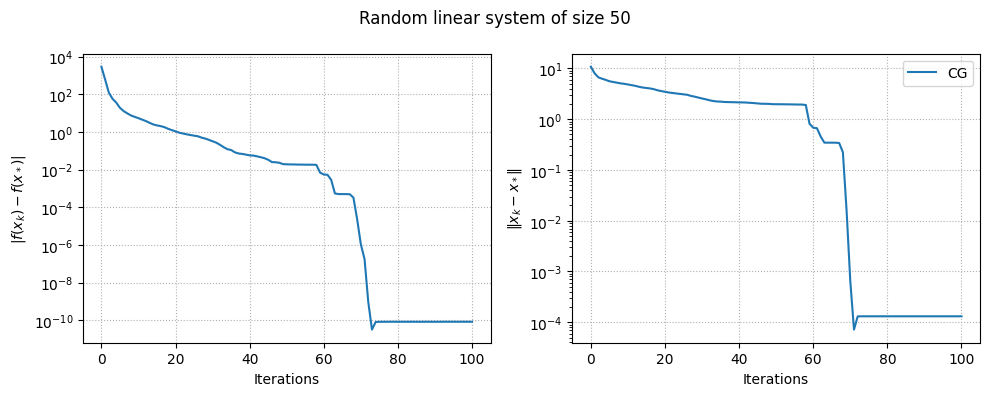

In [3]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plt.suptitle(f"Random linear system of size {n}")
ax1.set_xlabel("Iterations")
ax1.set_ylabel(f"$|f(x_k) - f(x_*)|$")
ax1.semilogy(metrics_cg["f_gap"])
ax1.grid(linestyle=":")

ax2.set_xlabel("Iterations")
ax2.set_ylabel(f"$\|x_k - x_*\|$")
ax2.semilogy(metrics_cg["x_gap"], label="CG")
ax2.legend()
ax2.grid(linestyle=":")

plt.tight_layout()
plt.show()

__Задача 2. (всего 3 балла)__ Рассмотрим следующую функцию:
$$f(x) = x_1^4 - 2 x_1^2 x_2 + x_1^2 + x_2^2 - 2x_1$$

Данная функция имеет минимум в точке $(x_1, x_2) = (1, 1)$.


__а\). (1 балл)__
Реализуйте обобщение метода сопряженных градиентов Флетчера -- Ривса.



**Псевдокод алгоритма**


_Инициализация:_ стартовая точка $x^0\in\mathbb{R}^d$, $p_0 = - \nabla f(x_0)$, количество итераций $K$

_k-ая итерация:_

1. Найдите $\alpha_k$, используя линейный поиск
2. $x^{k+1} = x^k + \alpha_k p_k$
3. $\beta_{k+1} = \frac{\langle \nabla f(x^{k+1}) , \nabla f(x^{k+1}) \rangle}{\langle \nabla f(x^k) , \nabla f(x^k) \rangle}$
4. $p_{k+1} = - \nabla f(x^{k+1}) + \beta_{k+1} p_k$

Для вашего удобства при реализации можете воспользоваться предложенным ниже кодом. После чего для проверки правильности загрузите функцию в [контест](https://contest.yandex.ru/contest/66540/enter/)

Постройте графики сходимости. Код построения также предложен ниже.

In [4]:
from scipy.optimize import minimize_scalar
import numpy as np

n = 2
x_0 = RNG.standard_normal((n,))
x_star = np.array([1.0, 1.0])


def f(x):
    return x[0] ** 4 - 2 * x[0] ** 2 * x[1] + x[0] ** 2 + x[1] ** 2 - 2 * x[0] + 1


def grad(x):
    return np.array([4 * x[0] ** 3 - 4 * x[0] * x[1] + 2 * x[0] - 2, -2 * x[0] ** 2 + 2 * x[1]])


def fletcher_reeves_cg_method(f=f, grad_f=grad, x_0=x_0,
                              x_star=x_star, n_iter=None):
    '''
        f - целевая функция
        grad_f - градиент целевой функции
        x_0 - стартовая точка
        x_star - точное решение
        n_iter - количество итераций (по умолчанию len(x_0))

        Функция возвращает словать, хранящий точки функции на каждой из итерации
    '''
    if n_iter is None:
        n_iter = len(x_0)
    x = x_0
    x_old = x_0
    p = -grad_f(x_0)
    f_star = f(x_star)

    trajectory = {}
    trajectory["f_gap"] = np.zeros(shape=n_iter + 1)
    trajectory["x_gap"] = np.zeros(shape=n_iter + 1)
    trajectory["f_gap"][0] = np.abs(f(x) - f_star)
    trajectory["x_gap"][0] = np.linalg.norm(x - x_star)

    for i in range(n_iter):
        alpha = minimize_scalar(lambda a: f(x + a * p)).x
        x_old = np.copy(x)
        x += alpha * p
        beta_k = np.square(grad_f(x)).sum() / np.square(grad_f(x_old)).sum()
        p = -grad(x) + beta_k * p

        trajectory["f_gap"][i + 1] = np.abs(f(x) - f_star)
        trajectory["x_gap"][i + 1] = np.linalg.norm(x - x_star)
    return trajectory

In [5]:
metrics_fr = fletcher_reeves_cg_method(n_iter=30)

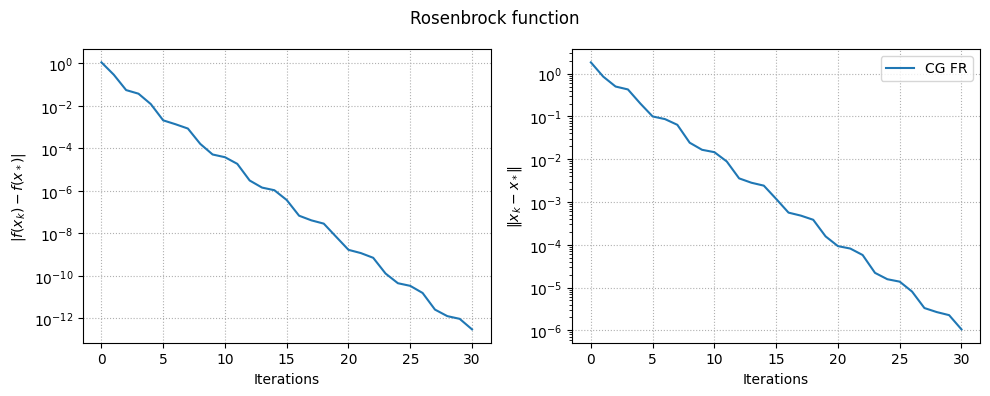

In [6]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plt.suptitle(f"Rosenbrock function")
ax1.set_xlabel("Iterations")
ax1.set_ylabel(f"$|f(x_k) - f(x_*)|$")
ax1.semilogy(metrics_fr["f_gap"])
ax1.grid(linestyle=":")

ax2.set_xlabel("Iterations")
ax2.set_ylabel(f"$\|x_k - x_*\|$")
ax2.semilogy(metrics_fr["x_gap"], label="CG FR")
ax2.legend()
ax2.grid(linestyle=":")

plt.tight_layout()
plt.show()

__б\). (1 балл)__
Реализуйте обобщение метода сопряженных градиентов Полака -- Рибьера.


**Псевдокод алгоритма**

_Инициализация:_ стартовая точка $x^0\in\mathbb{R}^d$, $p_0 = - \nabla f(x_0)$, количество итераций $K$

_k-ая итерация:_

1. Найдите $\alpha_k$, используя линейный поиск
2. $x^{k+1} = x^k + \alpha_k p_k$
3. $\beta_{k+1} = \frac{\langle \nabla f(x^{k+1}) , \nabla f(x^{k+1}) - \nabla f(x^{k}) \rangle}{\langle \nabla f(x^k) , \nabla f(x^k) \rangle}$
4. $p_{k+1} = - \nabla f(x^{k+1}) + \beta_{k+1} p_k$







Для вашего удобства при реализации можете воспользоваться предложенным ниже кодом. После чего для проверки правильности загрузите функцию в [контест](https://contest.yandex.ru/contest/66540/enter/)

In [7]:
from scipy.optimize import minimize_scalar

n = 2
x_0 = RNG.standard_normal((n,))
x_star = np.array([1.0, 1.0])


def f(x):
    return x[0] ** 4 - 2 * x[0] ** 2 * x[1] + x[0] ** 2 + x[1] ** 2 - 2 * x[0]


def grad_f(x):
    return np.array([4 * x[0] ** 3 - 4 * x[0] * x[1] + 2 * x[0] - 2, -2 * x[0] ** 2 + 2 * x[1]])


def polak_ribiere_cg_method(f=f, grad_f=grad, x_0=x_0,
                            x_star=x_star, n_iter=None):
    '''
        f - целевая функция
        grad_f - градиент целевой функции
        x_0 - стартовая точка
        x_star - точное решение
        n_iter - количество итераций (по умолчанию len(x_0))

        Функция возвращает словать, хранящий точки функции на каждой из итерации
    '''
    if n_iter is None:
        n_iter = len(x_0)
    x = x_0
    x_old = x_0
    p = -grad_f(x_0)
    f_star = f(x_star)

    trajectory = {}
    trajectory["f_gap"] = np.zeros(shape=n_iter + 1)
    trajectory["x_gap"] = np.zeros(shape=n_iter + 1)
    trajectory["f_gap"][0] = np.abs(f(x) - f_star)
    trajectory["x_gap"][0] = np.linalg.norm(x - x_star)

    for i in range(n_iter):
        alpha = minimize_scalar(lambda a: f(x + a * p)).x
        x_old = np.copy(x)
        x += alpha * p
        grad_x, grad_x_old = grad_f(x), grad_f(x_old)
        beta_k = np.dot(grad_x, grad_x - grad_x_old) / np.square(grad_x_old).sum()
        p = -grad(x) + beta_k * p

        trajectory["f_gap"][i + 1] = np.abs(f(x) - f_star)
        trajectory["x_gap"][i + 1] = np.linalg.norm(x - x_star)
    return trajectory

In [8]:
metrics_pr = polak_ribiere_cg_method(n_iter=30)

__в\). (1 балл)__
Постройте кривые сходимости метода Флетчера -- Ривса и метода Полака -- Рибьера на одном графике.

Сделайте вывод о сходимости методов. Какой из них сходится быстрее на рассматриваемой функции.

Для вашего удобства можете воспользоваться предложенным ниже кодом построения графиков.

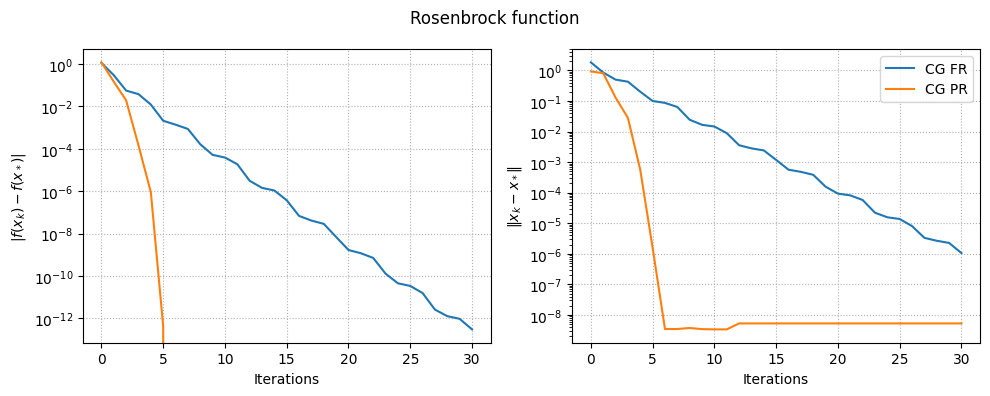

In [9]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plt.suptitle(f"Rosenbrock function")
ax1.set_xlabel("Iterations")
ax1.set_ylabel(f"$|f(x_k) - f(x_*)|$")
ax1.semilogy(metrics_fr["f_gap"], label="CG FR")
ax1.semilogy(metrics_pr["f_gap"], label="CG PR")
ax1.grid(linestyle=":")

ax2.set_xlabel("Iterations")
ax2.set_ylabel(f"$\|x_k - x_*\|$")
ax2.semilogy(metrics_fr["x_gap"], label="CG FR")
ax2.semilogy(metrics_pr["x_gap"], label="CG PR")
ax2.legend()
ax2.grid(linestyle=":")

plt.tight_layout()
plt.show()

## Дополнительная часть (Всего 5 баллов)

__Задача 1. (всего 3 балла)__  Снова рассмотрим квадратичную задачу :
$$\min_{x \in \mathbb{R}^d} \left[\tfrac{1}{2} x^T A x - b x \right]$$
с положительно определенной симметричной матрицей $A \in \mathbb{R}^{d \times d}$ и некоторым вектором $b \in \mathbb{R}^d$.

Исследуем особенности метода сопряженных градиентов, за которые он и получил популярность, как алгоритм численного решения системы линейных уравнений.
Для этого нам нужно научиться генерировать матрицу $A$ с возможнностью задавать ее спектр (собственные значения). В задании про градиентный спуск уже просили сделать это. Мы советуем использовать следующий подход, основанный на разложении $A = Q D Q^T$, где матрица $D$ - диагональная, образованная из собственных значений, а $Q$ - ортогональная (ее можно сгенерировать с помощью $QR$-разложения случайной матрицы).

Пусть у нас имеется квадратичная задача, у которой матрица $A \in \mathbb{R}^{d \times d}$ имеет кластеризованные собственные значения, это означает, что существует некоторое число кластеров $k \leq d$ и значения $\tilde \lambda_1 < \ldots < \tilde \lambda_k$, что для любого $\lambda_i$ собственного значения матрицы $A$ существует $j \leq k$ такой, что $\lambda_i \in [(1 - p) \tilde \lambda_j; (1 + p) \tilde \lambda_j]$, где $p < 1$.

Далее нужно будет генерировать кластеризованные собственные значения, а потом и матрицу $A$. Старайтесь при генерации спектра удостоверится, что все значения в нем разные. В качесве критерия сходимости используйте $\frac{\| x^k - x^* \|^2_A} {\| x^0 - x^* \|^2_A}$, где $k$ - номер итерации, а $\| x \|^2_A = \langle x, Ax \rangle$.

Протестируем работу метода сопряженных градиентов для различных вариантов кластеризации собственных значений:


__а\). (0.5 балла)__ Пусть $d = 100$, $k = 2$, $p = 0,05$, $\tilde \lambda_1 = 1$, в кластерах для $\tilde \lambda_1$ и $\tilde \lambda_2$ находится по 50 собственных значений. Варьируйте значение $\tilde \lambda_2$ от $10$ до $10^5$ (5 различных значений достаточно). На одном графике отобразите значения критерия сходимости от номера итерации для каждого значения $\tilde \lambda_2$.

In [10]:
# Ваше решение


# Также можете воспользоваться предложенным вариантом реализации кода генерации матрицы
from scipy.stats import ortho_group
import numpy as np

cluster_val_quantity = 50
clusters = [[cluster_val_quantity, i] for i in 10 ** np.linspace(1, 5, 5)]


def A_gen(d: int, clusters: list, p: float = 0.05) -> np.ndarray:
    '''
    d - размерность матрицы
    clusters - list, где каждый элемент есть [количество чисел в кластере, среднее значение в кластере]
    p - разброс значений в кластере
    '''
    eign_vals = []
    q_sum = 0
    for quantity, val in clusters:
        min_val = (1 - p) * val
        max_val = (1 + p) * val
        eign_vals.extend(min_val + np.random.random(quantity) * (max_val - min_val))
        q_sum += quantity
    if (q_sum != d):
        raise ValueError()
    np.random.shuffle(eign_vals)
    S = np.diag(eign_vals)
    U = ortho_group.rvs(d)
    return U.T @ S @ U


__б\). (0.5 балла)__ Пусть $d = 100$, $k = 2$, $p = 0,05$, $\tilde \lambda_1 = 1$, $\tilde \lambda_2 = 1000$. Варьируйте количество собственных значений в каждом из кластеров от $1$ до $99$ (5 различных значений достаточно). На одном графике отобразите значения критерия сходимости от номера итерации для каждого значения размера кластера для $\tilde \lambda_1$.

In [11]:
# Ваше решение

__в\). (0.5 балла)__ Пусть $d = 100$, $p = 0,05$, $\tilde \lambda_1 = 1$, $\tilde \lambda_k = 1000$. Варьируйте количество кластеров $k$ от 2 до 100 (5 различных значений достаточно, включите 100 - соотвествует равномерному распределению собственных значений). На одном графике отобразите значения критерия сходимости от номера итерации для каждого значения  $k$.

In [12]:
# Ваше решение

Опишите полученные результаты. Как Вы думаете, почему наблюдаются такие различия в сходимостях?

__Ваше решение__

__г\). (1.5 балла)__ Добавьте возможность рестарта алгоритма. Для этого нужно добавить возможность задавать $\beta_k = 0$ раз в несколько шагов. Общий вид алгоритма будет следующим:

**Псевдокод алгоритма**


_Инициализация:_ стартовая точка $x^0\in \mathbb{R}^d$, $r_0 = Ax_0 - b$, $p_0 = - r_0$, количество итераций $K$, количество шагов до рестарта $P_r$

_k-ая итерация:_

1. Обновляем параметр $\alpha$, иными словами минимизируем фукнцию $f(x^k - \alpha p_k)$ вдоль $p_k$
    $$\alpha_k = -\frac{r_k^T p_k}{p_k^T A p_k}$$
2. Делаем шаг
    $$x^{k+1} = x^k + \alpha_k p_k$$
3. 
    $$r_{k+1} = Ax^{k+1} - b$$
4. Найдем множитель $\xi$ при $\beta$ из множества $\{0,1\}$. 
    $$\text{Если }k \text{ кратно }P_r, \xi = 0, \text{иначе } \xi = 1$$
5. Находим коэффициент
    $$\beta_{k+1} = \frac{r_{k+1}^T A p_k}{p_k^T A p_k} \cdot \xi$$
6. Находим новый сопряженный вектор
    $$p_{k+1} = - r_{k+1} + \beta_{k+1} p_k$$

Запустите новый алгоритм с рестартами при условиях из пунктов а, б и в, но при одном значении вариации матрицы. Для пункта в задайте $k = 100$. 

Для каждого из пунктов добавьте на график результат алгоритма с рестартами и без рестартов.

In [13]:
# Ваше решение, пункт а

In [14]:
# Ваше решение, пункт б

In [15]:
# Ваше решение, пункт в

Сравните полученные результаты. Как думаете, почему наблюдается такой эффект?

__Ваше решение__

__Задача 2. (всего 2 балла)__ Рассмотрим следующую функцию, которая возникает в задачах машинного обучения (функция потерь логистической регрессии с $l_2$ регуляризацией). :

$$
\min_w \left[\frac1m \sum_{i=1}^m \log (1 + \exp(- y_i \langle x_i, w \rangle)) + \frac12 \|w\|_2^2\right]
$$


__а\). (1 балл)__
Реализуйте следующие методы для поиска минимума данной функции:
* метод Флетчера -- Ривса
* метод Полака -- Рибьера
* градиентный спуск с постоянным шагом
* градиентный спуск с линейным поиском

Для вашего удобства при реализации можете воспользоваться предложенным ниже кодом.


In [16]:
import numpy as np
import sklearn.datasets as skldata

n = 300
m = 1000

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m,
                                   n_informative=n // 3, random_state=0)
X = np.array(X)
y = np.array(y)


def f(w):
    return np.mean(np.logaddexp(np.zeros(X.shape[0]), -y * (X @ w))) + \
        np.linalg.norm(w) ** 2 / 2


def grad_f(x):
    # Ваше решение: реализуйте функцию расчета градиента
    pass


RNG = np.random.default_rng(seed=0)
sigma = 0
x0 = RNG.standard_normal((n,))
print(f"Initial function value = {f(x0)}")
print(f"Initial gradient norm = {np.linalg.norm(grad_f(x0))}")
# Ваше решение

Initial function value = 170.6762324941551


TypeError: unsupported operand type(s) for *: 'NoneType' and 'NoneType'


__б\). (1 балл)__
Постройте на одном графике кривые сходимости методов. Сделайте вывод о том, какой метод сходится быстрее на рассматриваемой функции.


In [ ]:
# Ваше решение